In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from librosa import display
from scipy import signal
from scipy import fft
import glob
import pyaudio
import struct
import IPython.display as ipd

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [81]:
#first load two musics into python and we can listen to the sample
ipd.Audio('/Users/changyuean/Python/Stanford/CS229Project/wav/2pac-trapped - 1.mp3')

In [82]:
ipd.Audio('/Users/changyuean/Python/Stanford/CS229Project/wav/10cc-for_you_and_i - 1.mp3')

In [75]:
#we can see that the length of these two music pieces are different. 
#In order to train CNN on them, I need to trim all music to the same length (in this case 3 second length)
#first load the mp3 file as data and frequency
#according to the paper "TOWARDS TIME-VARYING MUSIC AUTO-TAGGING BASED ON CAL500 EXPANSION", the authors 
#downsampled each sound file to 22,050 Hz and merge stereo to mono
#I will replicate the same process
data1, sampling_rate1 = librosa.core.load('/Users/changyuean/Python/Stanford/CS229Project/wav/2pac-trapped - 1.mp3',
                                        sr=22050, mono=True, duration = 3)
data2, sampling_rate2 = librosa.core.load('/Users/changyuean/Python/Stanford/CS229Project/wav/10cc-for_you_and_i - 1.mp3',
                                        sr=22050, mono=True, duration = 3)

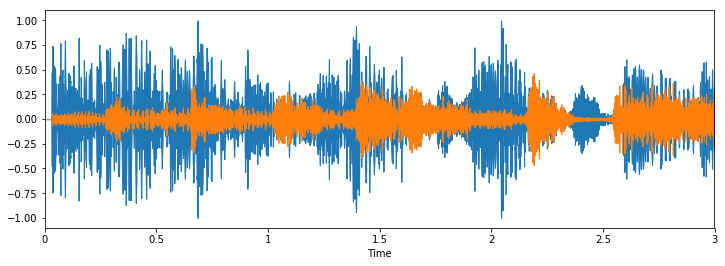

In [76]:
#visualize the wave plot
plt.figure(figsize=(12,4))
librosa.display.waveplot(data1, sr=sampling_rate1)
librosa.display.waveplot(data2, sr=sampling_rate2)

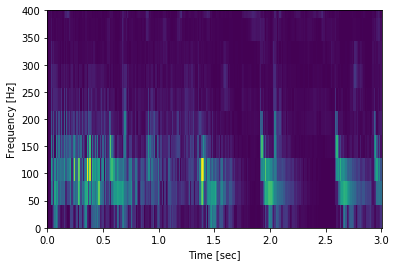

In [77]:
#according to the paper "CNN BASED MUSIC EMOTION CLASSIFICATION", the authors transformed the music into spectrogram
frequencies1, times1, spectrogram1 = signal.stft(data1,sampling_rate1, nperseg=512)
plt.ylim(0, 400) 
plt.pcolormesh(times1, frequencies1, np.abs(spectrogram1))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

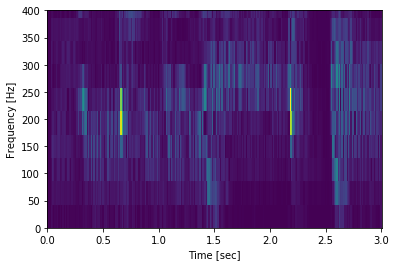

In [78]:
#according to the paper "CNN BASED MUSIC EMOTION CLASSIFICATION", the authors transformed the music into spectrogram
frequencies2, times2, spectrogram2 = signal.stft(data2,sampling_rate2, nperseg=512)
plt.ylim(0, 400) 
plt.pcolormesh(times2, frequencies2, np.abs(spectrogram2))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [124]:
# function to load label for a particular song
def load_label(label_dir, song_name):
    song_label = pd.read_csv(label_dir + song_name + ".csv")
    label = np.array(song_label["Song-Positive_Feelings"])
    return label

In [132]:
#function to read the mp3 data and pre-process it
def mp3_load_and_preprocess(data_dir, file_list, label_dir, segment_len = 512):
    
    songs = [line.rstrip('\n') for line in open(data_dir + file_list)]
    num_songs = len(songs)
    song_data_len = (int(segment_len/2) + 1)**2
    X = np.empty((song_data_len, num_songs))
    Y = np.empty((1, num_songs))
    #print(num_songs)
    #print(song_data_len)
    #print(X.shape)
    
    song_idx = 0
    for s in songs:
        #In order to train CNN on them, I need to trim all music to the same length (in this case 3 second length)
        #first load the mp3 file as data and frequency
        #according to the paper "TOWARDS TIME-VARYING MUSIC AUTO-TAGGING BASED ON CAL500 EXPANSION", the authors 
        #downsampled each sound file to 22,050 Hz and merge stereo to mono
        #I will replicate the same process
        song_data, sampling_rate = librosa.core.load(data_dir + s, sr=22050, mono=True, duration = 3)
        
        #according to the paper "CNN BASED MUSIC EMOTION CLASSIFICATION", the authors transformed the music into spectrogram
        frequencies, times, spectrogram = signal.stft(song_data,sampling_rate, nperseg=segment_len)
        
        # make the spectrogram a K x K matrix, with K = segment_len/2
        spect_dim = int(segment_len/2) + 1
        spect_subset = abs(spectrogram[0:spect_dim,0:spect_dim])
        spect_reshaped = spect_subset.reshape(-1,)
        
        X[:,song_idx] = spect_reshaped
        
        #get label for this song
        song_name_parts = s.split(" ") # split name based on spaces
        song_base_name = song_name_parts[0]
        label = load_label(label_dir, song_base_name)
        
        # add label to Y
        Y[:,song_idx] = label
        
        song_idx += 1
        
    return X, Y


In [ ]:
# load and pre-process data
data_directory = "/Users/changyuean/Python/Stanford/CS 229 Project/wav/"
file_list = "mp3.txt"
label_directory = "/Users/changyuean/Python/Stanford/CS 229 Project/SongLabelHard/"

X, Y = mp3_load_and_preprocess(data_directory, file_list, label_directory, segment_len=512)
print(X.shape)
print(Y.shape)
print(Y)

In [80]:
#Emotion Labels for "2pac-trapped" and "10cc-for_you_and_i"
pac1 = pd.read_csv("/Users/changyuean/Python/Stanford/CS229Project/SongLabelHard/2pac-trapped.csv")
pac_song_emo1 = np.array(pac1["Song-Positive_Feelings"])
pac2 = pd.read_csv("/Users/changyuean/Python/Stanford/CS229Project/SongLabelHard/10cc-for_you_and_i.csv")
pac_song_emo2 = np.array(pac2["Song-Positive_Feelings"])

two_song_emo = np.append(pac_song_emo1,pac_song_emo2,axis =0)
two_song_emo = two_song_emo.reshape(1,2)
print(two_song_emo)

[[0 1]]


In [9]:
print(spectrogram1.shape)


(257, 260)


In [10]:
spect_subset1 = abs(spectrogram1[0:257,0:257])
spect_subset2 = abs(spectrogram1[0:257,0:257])

In [11]:
print(spect_subset1.shape)

(257, 257)


In [12]:
X1 = spect_subset1.reshape(-1,1)
X2 = spect_subset2.reshape(-1,1)

In [13]:
print(X1.shape)

(66049, 1)


In [14]:
X = np.append(X1,X2, axis=1)

In [15]:
print(X.shape)

(66049, 2)


In [37]:
def initialize(X):
    W = np.random.randn(X.shape[0],1)
    b = np.zeros(1)
    return W, b

In [38]:
def sigmoid(X, W, b):
    W, b = initialize(X)
    Z = np.dot(W.T, X)+b
    A = 1/ (1+np.exp(-Z))
    return A

In [63]:
def cost_function(X, Y, W, b, r):
    m = X.shape[0]
    A = sigmoid(X, W, b)
    Y = two_song_emo
    cost = (-1/m)*np.sum(np.dot(Y,np.log(A).T)+np.dot(1-Y,np.log(1-A).T))
    dW = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum(A-Y)
    grads = {"dW":dW, 
             "db":db}
    return cost, grads

In [68]:
def optimize(W, b, X, Y, learning_rate, r):
    cost, grads = cost_function(X, Y, W, b, r)
    #update the W and b
    W = W - learning_rate*grads["dW"]
    b = b - learning_rate*grads["db"]
    
    cost_list = []
    cost_list.append(cost)
    params = {}
    prev_cost = None
    threshold = 1e-15
    iteration = 1
    while ((prev_cost is None or (abs(cost - prev_cost)>threshold)) and iteration<3000):
        prev_cost = cost
        cost, grads = cost_function(X, Y, W, b, r)
        W = W - learning_rate*grads["dW"]
        b = b - learning_rate*grads["db"]
        cost_list.append(cost)
        iteration = iteration+1
        if iteration%100==0:
            print("Cost after iteration %i: %f" %(iteration, cost))
    
    params["W"] = W
    params["b"] = b
    params["number of iterations"] = iteration
    
    return params, cost_list
        
    

In [69]:
#def prediction() will define later to predict new music

In [70]:
#define a main function to run the code
def main (X, Y, learning_rate = 0.001, regularization=0.001):
    W, b = initialize(X)
    #cost, grads = cost_function(X, Y, W, b, regularization)
    params, cost_list = optimize(W, b, X, Y, learning_rate, regularization)
    
    
    return params, cost_list

In [73]:
params, cost_list = main (X, two_song_emo, learning_rate = 0.001, regularization=1)

Cost after iteration 100: 0.000035
Cost after iteration 200: 0.000021
Cost after iteration 300: 0.000023
Cost after iteration 400: 0.000054
Cost after iteration 500: 0.000025
Cost after iteration 600: 0.000032
Cost after iteration 700: 0.000041
Cost after iteration 800: 0.000031
Cost after iteration 900: 0.000105
Cost after iteration 1000: 0.000026
Cost after iteration 1100: 0.000039
Cost after iteration 1200: 0.000021
Cost after iteration 1300: 0.000084
Cost after iteration 1400: 0.000052
Cost after iteration 1500: 0.000080
Cost after iteration 1600: 0.000030
Cost after iteration 1700: 0.000048
Cost after iteration 1800: 0.000037
Cost after iteration 1900: 0.000042
Cost after iteration 2000: 0.000026
Cost after iteration 2100: 0.000073
Cost after iteration 2200: 0.000023
Cost after iteration 2300: 0.000047
Cost after iteration 2400: 0.000056
Cost after iteration 2500: 0.000064
Cost after iteration 2600: 0.000059
Cost after iteration 2700: 0.000021
Cost after iteration 2800: 0.000026
C

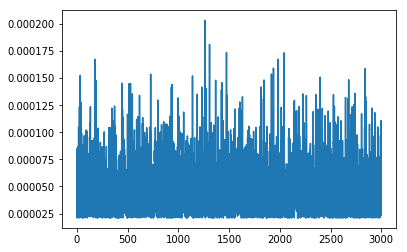

In [74]:
plt.plot(cost_list)